Loaded dataset: /Users/inesschwartz/Desktop/model/decluster_runs/decluster_run_001.csv
Total samples: 629
Training samples: 503, Test samples: 126

📈 Computing empirical variogram...

✅ Fitted Variogram Parameters:
  Nugget: 0.0000
  Sill:   0.2118
  Range:  12240.37 m


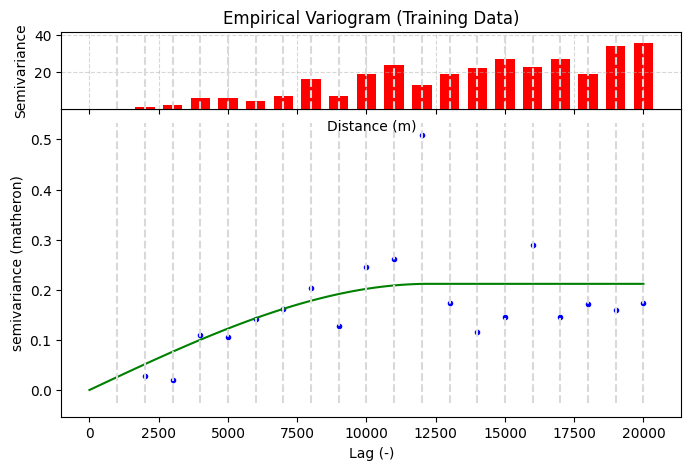


⚙️  Fitting Ordinary Kriging model...

🔮 Predicting SOC at test coordinates...

✅ Ordinary Kriging Validation Results:
  R²   = 0.069
  RMSE = 0.552


In [4]:
# =========================================================
# STEP — Ordinary Kriging workflow: variogram + interpolation
# =========================================================

import os
import pandas as pd
import numpy as np
from skgstat import Variogram
from pykrige.ok import OrdinaryKriging
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# --- Path to declustered subset directory ---
decluster_dir = "/Users/inesschwartz/Desktop/model/decluster_runs"

# --- Choose one representative declustered subset for testing ---
subset_file = os.path.join(decluster_dir, "decluster_run_001.csv")
df = pd.read_csv(subset_file)

print(f"Loaded dataset: {subset_file}")
print(f"Total samples: {len(df)}")

# =========================================================
# STEP 1 — Split training and test data
# =========================================================
target = "log_soc_stock"
coords_cols = ["X_coord", "Y_coord"]

train, test = train_test_split(df, test_size=0.2, random_state=42)
print(f"Training samples: {len(train)}, Test samples: {len(test)}")

coords_train = train[coords_cols].values
values_train = train[target].values
coords_test = test[coords_cols].values
values_test = test[target].values

# =========================================================
# STEP 2 — Compute empirical variogram on training data
# =========================================================
print("\n📈 Computing empirical variogram...")

V = Variogram(
    coords_train,
    values_train,
    model="spherical",  # or 'exponential', 'gaussian'
    maxlag=20000,       # maximum distance (20 km)
    n_lags=20,          # number of lag bins
    normalize=False
)

# --- Print fitted variogram parameters ---
# --- Extract variogram parameters safely (newer & older versions) ---
try:
    nugget = V.nugget
    sill = V.sill
    range_ = V.range
except AttributeError:
    params = V.describe()
    nugget = params.get('nugget', np.nan)
    sill = params.get('sill', np.nan)
    range_ = params.get('effective_range', np.nan)

print("\n✅ Fitted Variogram Parameters:")
print(f"  Nugget: {nugget:.4f}")
print(f"  Sill:   {sill:.4f}")
print(f"  Range:  {range_:.2f} m")

# --- Optional: visualize variogram ---
fig = V.plot(show=False)
plt.title("Empirical Variogram (Training Data)")
plt.xlabel("Distance (m)")
plt.ylabel("Semivariance")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

# =========================================================
# STEP 3 — Fit Ordinary Kriging model using fitted variogram
# =========================================================
print("\n⚙️  Fitting Ordinary Kriging model...")

ok = OrdinaryKriging(
    x=coords_train[:, 0],
    y=coords_train[:, 1],
    z=values_train,
    variogram_model="spherical",
    variogram_parameters={
        "nugget": nugget,
        "sill": sill,
        "range": range_
    },
    enable_plotting=False,
    verbose=False
)

# =========================================================
# STEP 4 — Predict SOC at test locations (model validation)
# =========================================================
print("\n🔮 Predicting SOC at test coordinates...")

z_pred, ss_pred = ok.execute("points", coords_test[:, 0], coords_test[:, 1])

# =========================================================
# STEP 5 — Validate OK model performance
# =========================================================
r2 = r2_score(values_test, z_pred)
rmse = np.sqrt(mean_squared_error(values_test, z_pred))
mae = mean_absolute_error(values_test, z_pred)

print("\n✅ Ordinary Kriging Validation Results:")
print(f"  R²   = {r2:.3f}")
print(f"  RMSE = {rmse:.3f}")


In [ ]:

# =========================================================
# STEP 6 — (Optional) Predict SOC over continuous grid (for map)
# =========================================================
# NOTE: Uncomment this section when you're ready to map Angola

# print("\n🗺️  Predicting SOC across grid (for map generation)...")
# min_x, max_x = df["X_coord"].min(), df["X_coord"].max()
# min_y, max_y = df["Y_coord"].min(), df["Y_coord"].max()

# gridx = np.linspace(min_x, max_x, 300)  # adjust resolution
# gridy = np.linspace(min_y, max_y, 300)

# z_grid, ss_grid = ok.execute("grid", gridx, gridy)

# plt.figure(figsize=(8, 6))
# plt.imshow(z_grid, origin="lower", extent=(min_x, max_x, min_y, max_y))
# plt.colorbar(label="Predicted log(SOC stock)")
# plt.title("Ordinary Kriging SOC Prediction Map")
# plt.xlabel("Easting")
# plt.ylabel("Northing")
# plt.show()